# Mapper Tutorial - the Santa Cloud

_Created by:_ Davide Burba, December 2019

In this notebook, we apply the [Mapper algorithm](https://research.math.osu.edu/tgda/mapperPBG.pdf)
to point cloud data by using [giotto-tda](https://giotto.ai),
an open-source Python library for topological data analysis.

# Import libraries

In [3]:
# data wrangling
import pandas as pd
import numpy as np

# tda filter function
from gtda.mapper.filter import Projection

# covers
from gtda.mapper.cover import (
    OneDimensionalCover, 
    CubicalCover
)

# tda magic
from gtda.mapper.pipeline import make_mapper_pipeline

# visualization
from gtda.mapper.visualization import (
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

# data viz
import plotly.graph_objects as go
from matplotlib.colors import to_rgba_array, to_rgba

# ml tools
from sklearn.cluster import DBSCAN

# turning off warning, if you want
import warnings
warnings.filterwarnings("ignore")

# Load and visualise data

The starting point for most Mapper analyses is a point cloud in an $n$-dimensional Euclidean space. For our purposes we'll use a dataset containing 20,000 points sampled from a Santa Claus shape in 3-dimensions.


_**Note:**_ The dataset has been sampled from a mesh object available [here](https://free3d.com/3d-model/santa-clau-77751.html) through the usage of [CloudCompare](https://www.cloudcompare.org).

In [4]:
data = pd.read_csv("../datasets/santa_data.csv")
data.head()

x         y         z  color
0  0.469986 -0.112556  0.276702    red
1  0.114129 -0.015158  0.774016  white
2 -0.080747 -0.000718 -0.999135  black
3  0.239434  0.001429  0.297960    red
4 -0.243728 -0.223468 -0.230000  white

As we can see, the data consists of 3-dimensional coordinates $ v_i = (x_i, y_i, z_i)$ for each point, along with a label for it's colour. Let's have a look at this 3-dimensional point cloud:

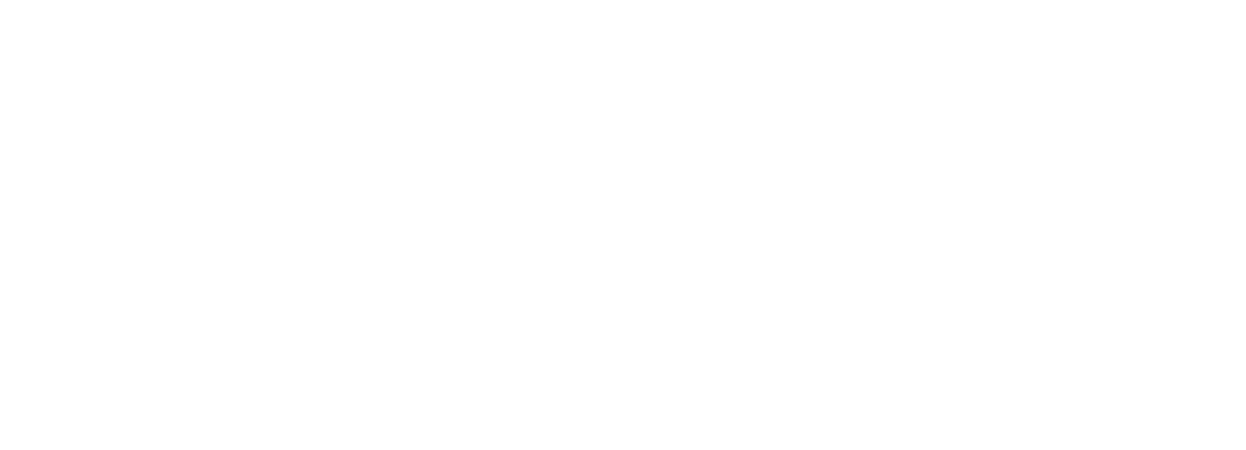

In [5]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=data.x,
            y=data.y,
            z=data.z,
            mode="markers",
            marker=dict(size=1, color=data.color,),
        )
    ]
)
fig.show()

# The Mapper algorithm

Let's consider an $n$-dimensional point cloud, i.e. a dataset with $n$ numerical features. The Mapper algorithm follows three main steps:

1. **_Filtering:_** map each data point $x \in \mathbb{R}^n$ to a low dimensional space $\mathbb{R}^m$ through a filter function $f: \mathbb{R}^n \to \mathbb{R}^m$
2. **_Covering:_** cover the mapped values $y = f(x)$ with overlapping intervals.
3. **_Clustering:_** for each interval, calculate the pre-image $x = f^{-1}(y)$ and apply a clustering algorithm on the set of points belonging to each pre-image.

The topological graph is then composed of:
- **nodes**: clusters
- **edges**: non-empty intersections between clusters

Even if its formulation could seem a bit intimidating, the best way to intuitively understand how the Mapper algorithm works is to use it and "play" with its parameters. The API of [giotto-tda](https://giotto.ai) is scikit-learn compatible and provides a very convenient way to fit the Mapper through a pipeline object.

We will apply the Mapper algorithm to the Santa Claus point cloud (the so-called "Santa Cloud"). Our goal is to get a minimal graph which preserves the topological properties of the original figure. 

First, let's define an array of coordinates to act as the point cloud to analyse:

In [6]:
coords = data[["x","y","z"]].values

## Identity as *filter*

The easiest way to produce a meaningful graph from a dataset is to use the identity as *filter* function. 

Formally, we map each vector of coordinates $\vec{v}_i$ to itself via $f: \vec{v} \to \vec{v}$. Since the mapped values lie in $\mathbb{R}^3$, we use a 3-dimensional cover.

In [13]:
def plot_mapper_graph_from_pipeline(pipe):
    """ A helper function, that plots the graph
    resulting from applying the pipeline `pipe`
    on the data.
    Parameters
    -----------
    pipe : 
    """
    # generate topological graph from point cloud
    graph = pipeline.fit_transform(coords)

    # get cluster member indices
    node_elements = graph["node_metadata"]["node_elements"]

    # configure choice of layout (x,z values)
    layout = np.array([np.mean(coords[el], axis=0)[[0,2]] for el in node_elements])

    # define node coloring
    node_colors = np.array([data.loc[el, "color"].value_counts().index[0] for el in node_elements])

    plotly_params = {
        'node_trace_marker_colorscale': None,
        'node_trace_marker_showscale': False
    }

    # initialise and display figure
    fig = plot_static_mapper_graph(pipeline, coords,
                                   layout, plotly_params=plotly_params)
    fig.update_traces(patch={'hoverlabel_bgcolor': node_colors,
                       'marker_color': node_colors})
    fig.show(config={'scrollZoom':True})
    
    return fig

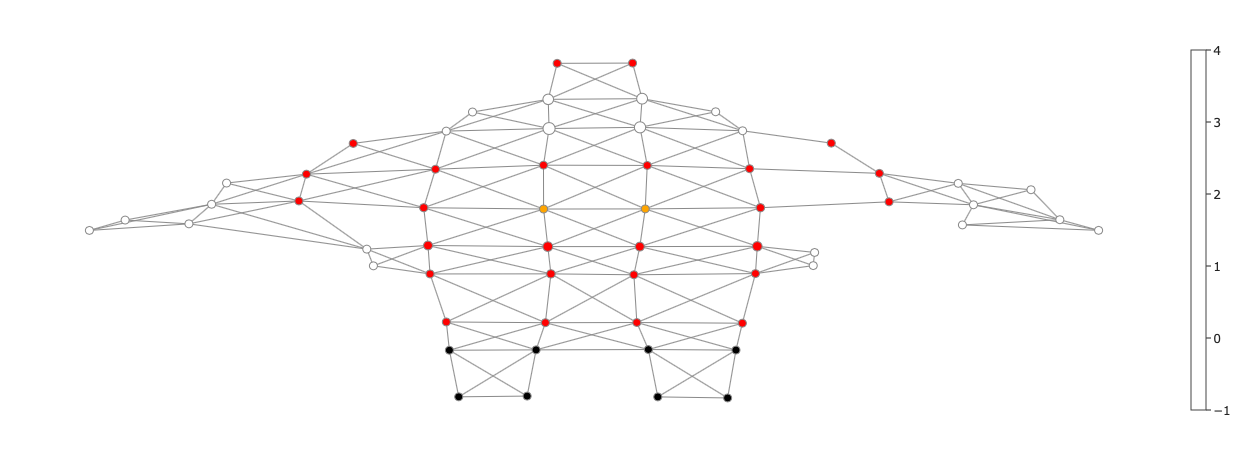

In [14]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=None,
    cover=CubicalCover(),
    clusterer=DBSCAN(),
)

# plot the graph arising from applying the pipeline
fig = plot_mapper_graph_from_pipeline(pipeline)

We can see that the Mapper output preserved the geometrical structure of Santa Claus. 
However, using the identity as *filter* function could be prohibitive in high dimensional spaces!

Let's try to build a more realistic example by using a 2D filter projection.

## 2D Projection

We map each vector of coordinates $\vec{v}_i = (x_i, y_i, z_i)$ to the $x$ and $z$ axis via $f: \vec{v} \to (x_i, z_i)$. Since the mapped values lie in $\mathbb{R}^2$, we use a 2-dimensional cover.


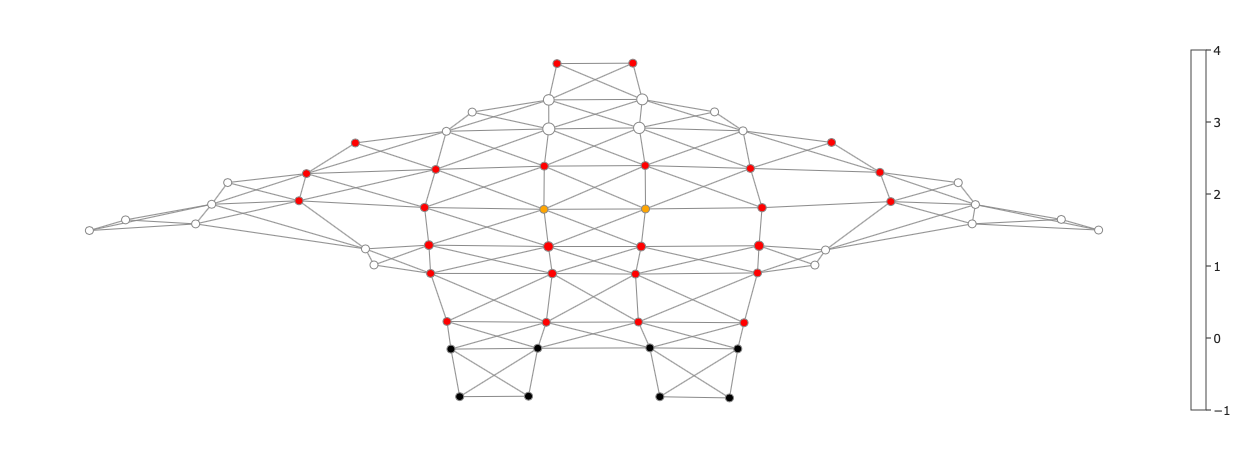

In [15]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=Projection(columns=[0,2]),
    cover=CubicalCover(),
    clusterer=DBSCAN(),
)

# plot the graph arising from applying the pipeline
fig = plot_mapper_graph_from_pipeline(pipeline)

We can see that we lost information on the Santa Claus depth, but we can clearly distinguish the figure anyway. Let's try to get an even more minimal graph with a 1-dimensional projection.


## Height as *filter* 

Let use the "height" of the Santa cloud as a filter function, i.e. we map each vector of coordinates $\vec{v}_i = (x_i, y_i, z_i)$ to the $z$-axis via $f: \vec{v} \to z$. Since the mapped values lie in $\mathbb{R}$, we use a 1-dimensional cover.

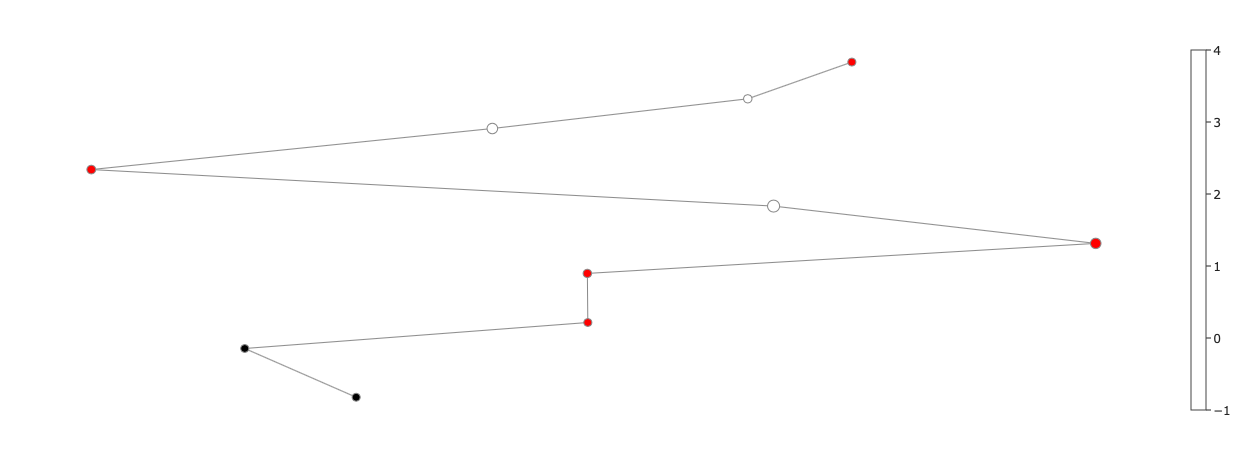

In [23]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=Projection(columns=2),
    cover=OneDimensionalCover(),
    clusterer=DBSCAN(),
)

# plot the graph arising from applying the pipeline
fig = plot_mapper_graph_from_pipeline(pipeline)

The graph is not very satisfactory as we cannot distinguish any part of Santa Claus' body. Since the graph corresponds to a line of connected points, it means that the clustering algorithm always returned a unique cluster for each interval in the cover. 

### Tweak clustering parameters

Let's try to use more **restrictive clustering parameters**.

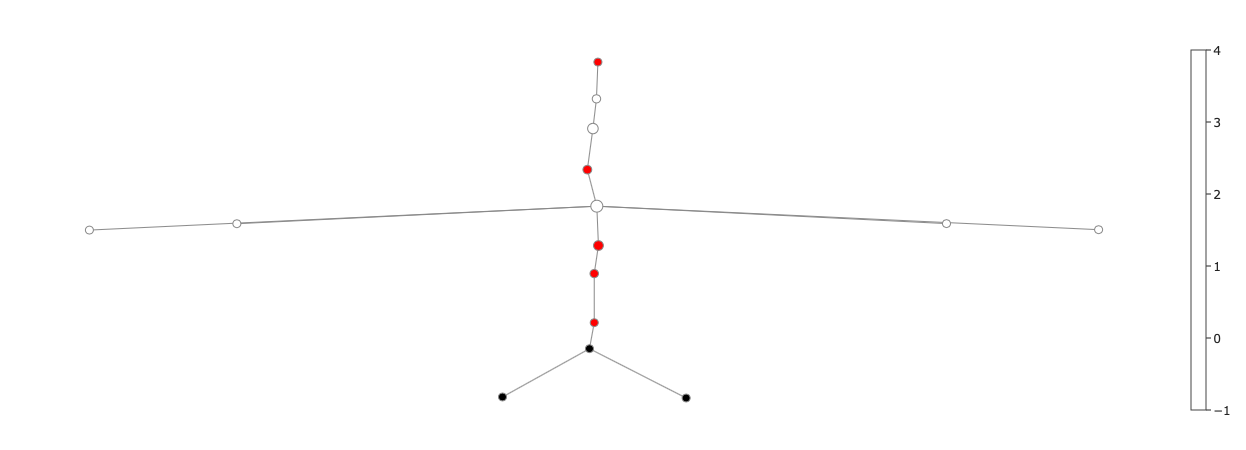

In [17]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=Projection(columns=2),
    cover=OneDimensionalCover(),
    clusterer=DBSCAN(eps=0.06),
)

# plot the graph arising from applying the pipeline
fig = plot_mapper_graph_from_pipeline(pipeline)

We can now distinguish the two legs, but if you zoom in you can see that Santa now has 4 arms! 

### Tweak overlap fraction of cover intervals

We need to **increase the overlapping fraction** of the intervals.

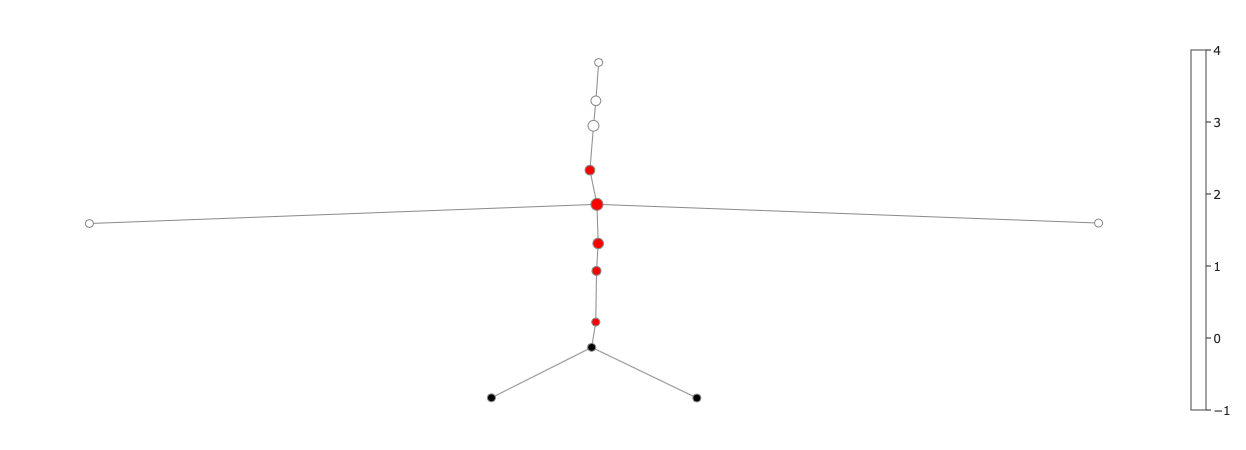

In [18]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=Projection(columns=2),
    cover=OneDimensionalCover(overlap_frac=0.35),
    clusterer=DBSCAN(eps=0.06),
)

# plot the graph arising from applying the pipeline
fig = plot_mapper_graph_from_pipeline(pipeline)

Now we can clearly distinguish the legs, the arms and the head.

### Tweak number of intervals in cover

Let's see what happens if we **increase the number of intervals** in the cover to 20 (default is 10).

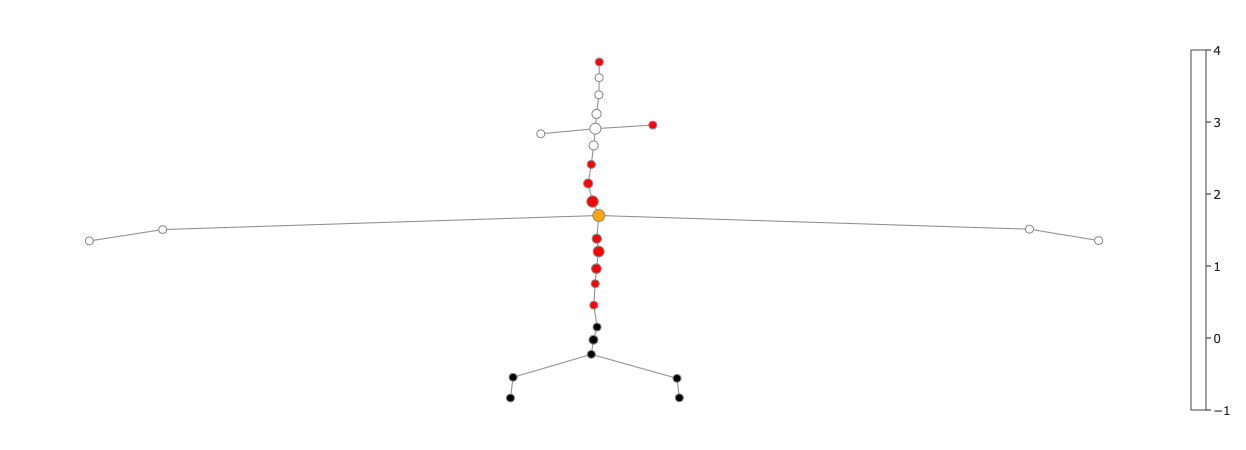

In [19]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=Projection(columns=2),
    cover=OneDimensionalCover(n_intervals=20, overlap_frac=0.35),
    clusterer=DBSCAN(eps=0.06),
)

# plot the graph arising from applying the pipeline
fig = plot_mapper_graph_from_pipeline(pipeline)

If we increase the number of bins in the cover to 20, we see the appearance of a node representing the hat and a branch separating the chest from the beard

# Interactive mode

As we saw above, it takes several steps of interation to obtain a topological Mapper graph that accurately captures the underlying structure of the point cloud. To help speedup the iterations, [giotto-tda](https://giotto.ai) provides the option to dynamically change the Mapper parameters and see how this affects the output!

In [22]:
# configure Mapper pipeline
pipeline = make_mapper_pipeline(
    filter_func=Projection(columns=2),
    cover=OneDimensionalCover(),
    clusterer=DBSCAN(),
)

# generate figure
plot_interactive_mapper_graph(pipeline, coords)